In [8]:
import numpy as np
import cv2 
import sys
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib as mpl

In [9]:
'''
image 1: g_true = [[],
                   [],
                   [],
                   [0,0,0,1]]  # [R p]
                   
                   Euler angles, quaternion. Scipy -- how to compute Rotation matrices

'''

'\nimage 1: g_true = [[],\n                   [],\n                   [],\n                   [0,0,0,1]]  # [R p]\n                   \n                   Euler angles, quaternion. Scipy -- how to compute Rotation matrices\n\n'

In [10]:
vid = cv2.VideoCapture(0)

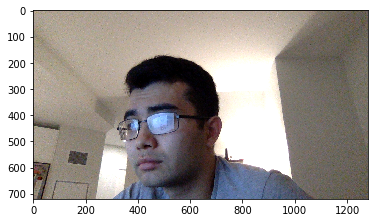

In [11]:
res, im = vid.read()
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [12]:
im.shape

(720, 1280, 3)

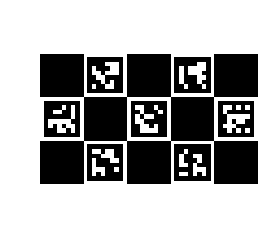

In [38]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
board = aruco.CharucoBoard_create(5, 3, 1.2, 1, aruco_dict)
imboard = board.draw((2000, 2000))
# cv2.imwrite(workdir + "chessboard.tiff", imboard)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.show()


In [34]:
aruco_dict.

SyntaxError: invalid syntax (<ipython-input-34-fa43883221e3>, line 1)

In [28]:
aruco.DICT_ARUCO_ORIGINAL

16

In [40]:
imboard.shape

(2000, 2000)

CPU times: user 92 ms, sys: 26.4 ms, total: 118 ms
Wall time: 86.9 ms


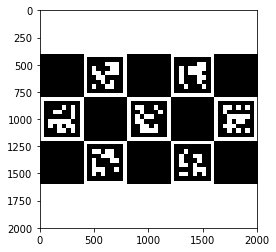

In [44]:
%time plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")